# Data Challenge HEC 2024

In [ ]:
# Load file from drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Note: I cannot share this dataset publicly

In [ ]:
import os
os.chdir("drive/MyDrive/data_challenge_HEC_Invent")

In [ ]:
!python3 -m pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.1
    Uninstalling transformers-4.41.1:
      Successfully uninstalled transformers-4.41.1


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from pprint import pprint

# Gensim
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Load Data

In [ ]:
#TO DO: Load the parquet file (type: pd.DataFrame)
path = "data/reviews_cleaned.parquet"
reviews = pd.read_parquet(path)

In [ ]:
# TO DO : Check Review variables
# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(reviews.head())

# Display the column names
print("\nColumn names in the DataFrame:")
print(reviews.columns)

# Get summary statistics
print("\nSummary statistics of the DataFrame:")
print(reviews.describe())

# Check for missing values
print("\nMissing values in the DataFrame:")
print(reviews.isnull().sum())

First few rows of the DataFrame:
   Unnamed: 0  page                                              titre  \
0           0     1                           Aucun soucis particulier   
1           1     1            Engie facture a ses clients des sommes…   
2           2     1   Facturation sur consommation d'un autre logement   
3           3     1                un service client ou il est dur de…   
4           4     1  Client d'ENGIE depuis longtemps toujours satis...   

                                            verbatim               date  note  \
0  Je paie ma facture tous les deux mois en fonct...   Il y a 17 heures     4   
1  Engie facture a ses clients des sommes exorbit...     Il y a un jour     1   
2  Ils me facturent sur le pdl du logement au des...     ll y a 3 jours     1   
3  un service client ou il est dur de comprendre ...     ll y a 3 jours     1   
4  Excellente expérience avec ENGIE et une interl...  Il y a 24 minutes     5   

                                   

In [ ]:
### Exemple of preprocessing already done
print(reviews["verbatim"][1])
print('----------')
print(reviews["tokens_lem_processed"][1])

Engie facture a ses clients des sommes exorbitants !

Engie mon facturer un technicien pour le gaz , alors que GRDF m’a bien préciser que le gaz était déjà en service dans mon logement ! Résultat des courses une facture de 71 euros juste pour ouvrir le compteur électrique de mon nouveau logement , concernant le gaz personne est intervenu sur ma chaudière j’ai dû le faire tout seul !

Engie savent prendre l’argent à tord mais quand ont leur explique malheureusement plus personne est là !
----------
['engi' 'factur' 'client' 'somm' 'exorbit' 'engi' 'factur' 'technicien'
 'gaz' 'alor' 'grdf' 'précis' 'gaz' 'déjà' 'servic' 'dan' 'log' 'résultat'
 'cours' 'factur' 'euros' 'ouvr' 'compteur' 'électr' 'log' 'concern' 'gaz'
 'person' 'intervenu' 'chaudi' 'dû' 'fair' 'engi' 'savent' 'prendr'
 'argent' 'tord' 'expliqu' 'malheur' 'person']


<ipython-input-8-dfee6378b428>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="note", data=reviews, palette='viridis')


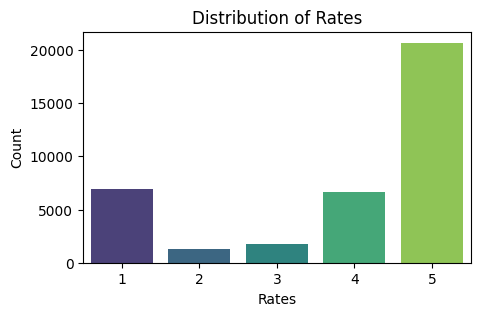

In [ ]:
# TO DO: plot an histogram for this categorical variable: rates (column "note" in the dataset)
# Create a countplot for the 'rates' variable
plt.figure(figsize=(5, 3))
sns.countplot(x="note", data=reviews, palette='viridis')

# Add a title and labels to the axes
plt.title("Distribution of Rates")
plt.xlabel("Rates")
plt.ylabel("Count")

# Show the countplot
plt.show()

# Topic Extraction

In this section will make topic extraction using LDA (Latent Dirichlet Allocation) with Gensim library.
It helps to identify topics in a collection of documents. It assumes that each document is made up of various topics, and each topic is made up of certain words.

By using LDA, we can find out what topics are present in a set of documents and which words are associated with each topic.

## Preprocessing of reviews

In [ ]:
'''
TO DO : Create a dictionary from 'tokens_lem_processed' containing the number of times a word appears
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
tokens = reviews['tokens_lem_processed'].tolist()
dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<13690 unique tokens: ['agréabl', 'ailleur', 'besoin', 'bénéfici', 'client']...>


In [ ]:
'''
TO DO : Remove very rare and very common words:
- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
# Print the dictionary again to see the reduced number of tokens
print(dictionary)


Dictionary<2225 unique tokens: ['agréabl', 'ailleur', 'besoin', 'bénéfici', 'compréhens']...>


In [ ]:
'''
TO DO : Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'corpus' (HINT: check dictionary.doc2bow(tokens[0]))
'''
corpus = [dictionary.doc2bow(tok) for tok in tokens]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 4), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [ ]:
'''
Preview BOW for our sample preprocessed document
'''
review_num = 20
bow_doc_x = corpus[review_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0],
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Word 144 ("tarif") appears 1 time.
Word 197 ("fournisseur") appears 1 time.
Word 199 ("prix") appears 1 time.
Word 200 ("rapid") appears 1 time.
Word 281 ("apprec") appears 1 time.
Word 282 ("blocag") appears 1 time.
Word 283 ("efficac") appears 1 time.
Word 284 ("possibil") appears 1 time.


## Train LDA Model

In [ ]:
# TO DO: build lda model
'''
Train your lda model using gensim.models.ldamodel.LdaModel
'''
nb_topics = 10
alpha = 0.1
eta = 0.1
random_state = 42
np.random.seed(random_state)

ldaModel = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=nb_topics,
                    alpha=alpha,
                    eta=eta,
                    random_state=random_state,
                    passes=10,
                    iterations=400)
# Print the top 10 words for each topic
topics = ldaModel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.118*"conseil" + 0.042*"expliqu" + 0.033*"question" + 0.029*"téléphon" + 0.024*"contact" + 0.024*"clair" + 0.020*"attent" + 0.018*"souscript" + 0.017*"répons" + 0.017*"temp"')
(1, '0.115*"compétent" + 0.078*"sérieux" + 0.053*"dan" + 0.039*"projet" + 0.034*"entrepris" + 0.032*"ras" + 0.024*"confianc" + 0.023*"cordial" + 0.022*"enr" + 0.021*"présent"')
(2, '0.028*"factur" + 0.024*"mois" + 0.019*"contrat" + 0.017*"pai" + 0.013*"demand" + 0.012*"mail" + 0.011*"appel" + 0.011*"jour" + 0.010*"mêm" + 0.010*"san"')
(3, '0.041*"votr" + 0.025*"fair" + 0.022*"avis" + 0.017*"comm" + 0.011*"vrai" + 0.010*"cel" + 0.009*"commentair" + 0.009*"mieux" + 0.008*"voir" + 0.008*"fonction"')
(4, '0.099*"total" + 0.083*"énerg" + 0.072*"fournisseur" + 0.043*"energ" + 0.040*"chang" + 0.031*"électr" + 0.031*"direct" + 0.020*"gaz" + 0.020*"contrat" + 0.019*"compet"')
(5, '0.204*"rapid" + 0.088*"efficac" + 0.080*"souscript" + 0.079*"facil" + 0.062*"simpl" + 0.045*"clair" + 0.029*"sit" + 0.018*"mis" + 0.018*"

In [ ]:
ldaModel.show_topics()

[(0,
  '0.118*"conseil" + 0.042*"expliqu" + 0.033*"question" + 0.029*"téléphon" + 0.024*"contact" + 0.024*"clair" + 0.020*"attent" + 0.018*"souscript" + 0.017*"répons" + 0.017*"temp"'),
 (1,
  '0.115*"compétent" + 0.078*"sérieux" + 0.053*"dan" + 0.039*"projet" + 0.034*"entrepris" + 0.032*"ras" + 0.024*"confianc" + 0.023*"cordial" + 0.022*"enr" + 0.021*"présent"'),
 (2,
  '0.028*"factur" + 0.024*"mois" + 0.019*"contrat" + 0.017*"pai" + 0.013*"demand" + 0.012*"mail" + 0.011*"appel" + 0.011*"jour" + 0.010*"mêm" + 0.010*"san"'),
 (3,
  '0.041*"votr" + 0.025*"fair" + 0.022*"avis" + 0.017*"comm" + 0.011*"vrai" + 0.010*"cel" + 0.009*"commentair" + 0.009*"mieux" + 0.008*"voir" + 0.008*"fonction"'),
 (4,
  '0.099*"total" + 0.083*"énerg" + 0.072*"fournisseur" + 0.043*"energ" + 0.040*"chang" + 0.031*"électr" + 0.031*"direct" + 0.020*"gaz" + 0.020*"contrat" + 0.019*"compet"'),
 (5,
  '0.204*"rapid" + 0.088*"efficac" + 0.080*"souscript" + 0.079*"facil" + 0.062*"simpl" + 0.045*"clair" + 0.029*"sit" 

In [ ]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

In [ ]:
coherence

-3.309186830694505

The coherence value evaluates how often words in a topic co-occur in the original documents.

Generally, higher coherence values indicate better coherence and interpretability of topics. However, what constitutes a "good" value can depend on the specific dataset and the nature of the text being modeled.

In [ ]:
#pyLDAvis visualisation
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldaModel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.175448  0.151297       1        1  37.618948
8      0.103082  0.206803       2        1  13.966044
3      0.156129  0.094432       3        1   9.713281
0     -0.080188  0.178167       4        1   8.682854
4      0.135287 -0.140461       5        1   6.828595
9      0.170324 -0.249834       6        1   6.398354
7     -0.310000  0.029396       7        1   5.512525
5     -0.261716 -0.099790       8        1   4.196973
6     -0.005176 -0.229588       9        1   3.658619
1     -0.083188  0.059578      10        1   3.423808, topic_info=              Term         Freq        Total Category  logprob  loglift
200          rapid  3994.000000  3994.000000  Default  30.0000  30.0000
245        conseil  4792.000000  4792.000000  Default  29.0000  29.0000
224          total  3550.000000  3550.000000  Default  28.0000  28.0000
51      technicien  4364.000000  4364.000000  Default  27.0000  27.0000
168  professionnel  2692.000000  2692.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
437        bonjour   136.937544   479.522327  Topic10  -4.7600   2.1212
425           merc   178.641787  1726.629268  Topic10  -4.4942   1.1059
422         societ   129.330765   512.511269  Topic10  -4.8172   1.9975
403           temp   158.740750  1690.861785  Topic10  -4.6123   1.0087
96      commercial   127.846138  1053.330977  Topic10  -4.8287   1.2655

[579 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
263       1  0.477358     abon
263       2  0.000721     abon
263       5  0.121863     abon
263       6  0.399481     abon
204       1  0.996265     abus
...     ...       ...      ...
203       5  0.947659    énerg
2050     10  0.964584  énerget
453       1  0.352208    étoil
453       3  0.645245    étoil
397       3  0.988610    évolu

[946 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 4, 1, 5, 10, 8, 6, 7, 2])

In [ ]:
# TO DO: what do you observe in these plot ?

...

# How to choose the good number of topics ?

In [ ]:
# TO DO:
# See wich one seems to be the best.
# You can also make some research about coherence value to explain your analysis.
# Finally, how could you improve this result.

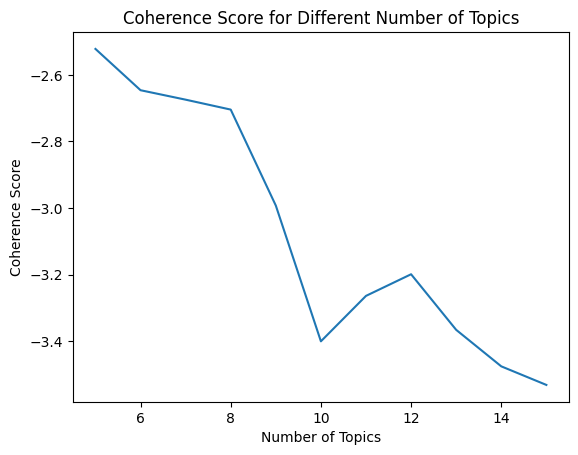

In [ ]:
# TO DO: complete this function to get coherence value for different nb_topics

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    start : Minimum number of topics (default is 2)
    step : Step size (default is 3)

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                alpha=0.01,
                                                eta=0.01,
                                                passes=10,
                                                iterations=400,
                                                random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Example usage
limit = 16
start = 5
step = 1

model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokens, limit, start, step)

# Plot coherence values
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score for Different Number of Topics")
plt.show()

In [ ]:
alpha_values = [0.01, 0.1, 0.5, 'auto']
eta_values = [0.01, 0.1, 0.5, 'auto']
results = {}
for alpha in alpha_values:
    for eta in eta_values:
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=nb_topics,
                                                random_state=random_state,
                                                alpha=alpha,
                                                eta=eta)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='u_mass')
        coherence = coherencemodel.get_coherence()
        results[(alpha, eta)] = coherence

best_params = max(results, key=results.get)
best_coherence = results[best_params]
print(f"Best Parameters: alpha={best_params[0]}, eta={best_params[1]} with coherence={best_coherence}")

Best Parameters: alpha=0.5, eta=0.01 with coherence=-2.9263034725957366


In [ ]:
# TO DO: get the optimal model and print the first 10 words
from pprint import pprint

# Find the index of the model with the highest coherence value
optimal_index = coherence_values.index(max(coherence_values))

# Get the optimal model
optimal_model = model_list[optimal_index]

# Show the topics in the optimal model
model_topics = optimal_model.show_topics(formatted=False)

# Print the top 10 words for each topic
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.065*"conseil" + 0.052*"expliqu" + 0.051*"écout" + 0.051*"rapid" + '
  '0.047*"clair" + 0.030*"efficac" + 0.027*"agréabl" + 0.026*"professionnel" + '
  '0.021*"parf" + 0.021*"question"'),
 (1,
  '0.102*"technicien" + 0.050*"professionnel" + 0.048*"intervent" + '
  '0.031*"tre" + 0.027*"compétent" + 0.027*"entretien" + 0.026*"sérieux" + '
  '0.026*"merc" + 0.025*"sympath" + 0.022*"person"'),
 (2,
  '0.019*"contrat" + 0.018*"appel" + 0.014*"factur" + 0.014*"demand" + '
  '0.012*"mois" + 0.011*"jour" + 0.011*"san" + 0.011*"téléphon" + '
  '0.010*"électr" + 0.010*"fair"'),
 (3,
  '0.021*"dan" + 0.016*"install" + 0.014*"technicien" + 0.013*"chaudi" + '
  '0.012*"chauffag" + 0.012*"eau" + 0.011*"jour" + 0.011*"heur" + 0.010*"san" '
  '+ 0.009*"fonction"'),
 (4,
  '0.044*"prix" + 0.033*"tarif" + 0.033*"fournisseur" + 0.031*"énerg" + '
  '0.030*"total" + 0.025*"offre" + 0.020*"électr" + 0.019*"consomm" + '
  '0.016*"moin" + 0.016*"energ"')]


In [ ]:
# TO DO:
# You can also make some research about coherence value to explain your analysis.
# Finally, how could you improve this result ?

In [ ]:
# pyLDAvis visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.151641 -0.125776       1        1  56.519695
3     -0.108135 -0.225689       2        1  13.872930
4     -0.214408  0.271386       3        1  12.581783
0      0.203524  0.103733       4        1  10.377840
1      0.270660 -0.023655       5        1   6.647752, topic_info=           Term         Freq        Total Category  logprob  loglift
51   technicien  4038.000000  4038.000000  Default  30.0000  30.0000
245     conseil  4860.000000  4860.000000  Default  29.0000  29.0000
251       écout  2475.000000  2475.000000  Default  28.0000  28.0000
37      expliqu  3528.000000  3528.000000  Default  27.0000  27.0000
200       rapid  3177.000000  3177.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
79         pass   418.389972  2560.513137   Topic5  -4.3067   0.8993
245     conseil   483.425613  4860.769807   Topic5  -4.1622   0.4028
283     efficac   322.398301  1780.806713   Topic5  -4.5673   1.0019
266     contact   296.326376  2556.237137   Topic5  -4.6516   0.5561
626   entrepris   250.044089   870.252081   Topic5  -4.8214   1.4637

[345 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
263       1  0.517398       abon
263       3  0.483244       abon
2069      4  0.992986    acceuil
1062      1  0.077518  accompagn
1062      4  0.917295  accompagn
...     ...       ...        ...
23        3  0.304487     électr
344       1  0.212832       élev
344       3  0.786984       élev
203       1  0.292065      énerg
203       3  0.707952      énerg

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2])

# Sentiment Analysis

In this section we will show how to perform the sentiment analysis of the sentences.
In this case we are going to allow the package called Vader because it is simple to use and provides good results in examples like the one we are studying.

This package is able to assign a compound score to a sentence with the following idea behind:
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

More information on this package can be found here: https://github.com/cjhutto/vaderSentiment...

Let's try it out for a single sentence!

In [ ]:
!pip install vaderSentiment_fr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for vaderSentiment_fr: filename=vaderSentiment_fr-1.3.4-py3-none-any.whl size=185962 sha256=ae42a1738129cc37d73ae258e557acc7296cac929b5c694747642019e1a31e32
  Stored in directory: /root/.cache/pip/wheels/a3/a0/97/307bbd5f16d2e240c69421a79a42a18797067af832ee955b09
Successfully built vaderSentiment_fr


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


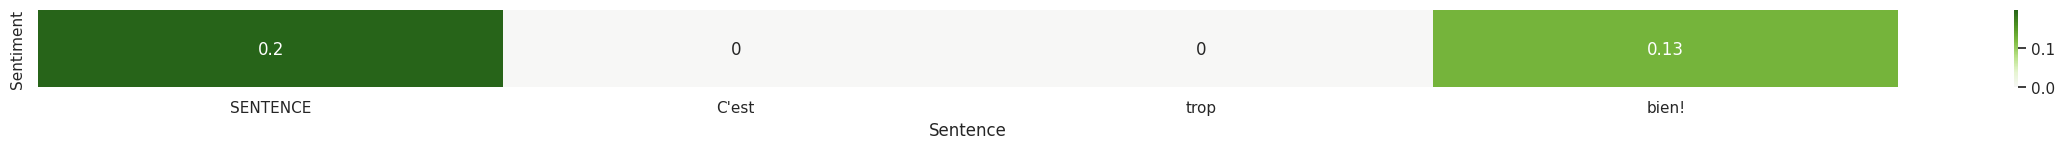

In [ ]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

sentence = "C'est trop bien! "

# Analyze sentiment
sentence_sentiment = analyzer.polarity_scores(sentence)["compound"]
word_sentiments = [analyzer.polarity_scores(word)["compound"] for word in sentence.split()]

# Prepare data for visualization
sentiment_data = {
    "Sentence": ["SENTENCE"] + sentence.split(),
    "Sentiment": [sentence_sentiment] + word_sentiments
}

# Define the visualization function
def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T, center=0, annot=True, cmap="PiYG")

# Set the figure size
sns.set(rc={'figure.figsize': (30, 1)})

# Visualize the sentiments
visualise_sentiments(sentiment_data)
plt.show()

But now let's apply this to our reviews dataset. Try creating a function that assigns a sentiment to each of the reviews:

In [ ]:
def extract_score(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']

    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return sentiment

# Apply this function to the reviews dataset
reviews['sentiment'] = reviews['verbatim'].apply(extract_score)

# Display the first few rows with the new sentiment column
reviews.head()

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed,sentiment
0,0,1,Aucun soucis particulier,Je paie ma facture tous les deux mois en fonct...,Il y a 17 heures,4,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,je paie ma facture tous les deux mois en fonct...,"[[je, ], [paie, ], [ma, ], [facture, ], [tous,...","[[je, ], [pai, ], [ma, ], [factur, ], [tous, ]...","[paie, facture, mois, fonction, consommation, ...","[pai, factur, mois, fonction, consomm, exact, ...",positive
1,1,1,Engie facture a ses clients des sommes…,Engie facture a ses clients des sommes exorbit...,Il y a un jour,1,"Bonjour Julien Blanco,\n\nPour des raisons de ...",Date de l'expérience: 26 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,engie facture a ses clients des sommes exorbit...,"[[engie, ], [facture, ], [a, ], [ses, ], [clie...","[[engi, ], [factur, ], [a, ], [se, ], [client,...","[engie, facture, clients, exorbitants, engie, ...","[engi, factur, client, somm, exorbit, engi, fa...",negative
2,2,1,Facturation sur consommation d'un autre logement,Ils me facturent sur le pdl du logement au des...,ll y a 3 jours,1,"Bonjour BlooDz,\n\nPour des raisons de confide...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,ils me facturent sur le pdl du logement au des...,"[[ils, ], [me, ], [facturent, ], [sur, ], [le,...","[[il, ], [me, ], [facturent, ], [sur, ], [le, ...","[facturent, pdl, logement, disant, faute, jama...","[facturent, pdl, log, dis, faut, jam, pris, fa...",positive
3,3,1,un service client ou il est dur de…,un service client ou il est dur de comprendre ...,ll y a 3 jours,1,"Bonjour Ricanto77,\nPour des raisons de confid...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,un service client ou il est dur de comprendre ...,"[[un, ], [service, ], [client, ], [ou, ], [il,...","[[un, ], [servic, ], [client, ], [ou, ], [il, ...","[service, client, dur, comprendre, langue, uti...","[servic, client, dur, comprendr, langu, utilis...",negative
4,4,1,Client d'ENGIE depuis longtemps toujours satis...,Excellente expérience avec ENGIE et une interl...,Il y a 24 minutes,5,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,excellente expérience avec engie et une interl...,"[[excellente, ], [expérience, ], [avec, ], [en...","[[excellent, ], [expérient, ], [avec, ], [engi...","[excellente, expérience, engie, interlocutrice...","[excellent, expérient, engi, interlocutric, so...",positive


In [ ]:
reviews = reviews[["verbatim", "note"]]

reviews["predicted_sentiment"] = reviews["verbatim"].apply(extract_score)

# Data Analysis

We have now show you different NLP techniques that can be used in our use case. Now it is up to you to use them in order to create some personalized analysis on the text data.

**######Analysis 1######**

<ipython-input-29-daf272e85239>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='aspect_sentiments', y='aspects', data=aspect_sentiment_summary, palette='coolwarm')


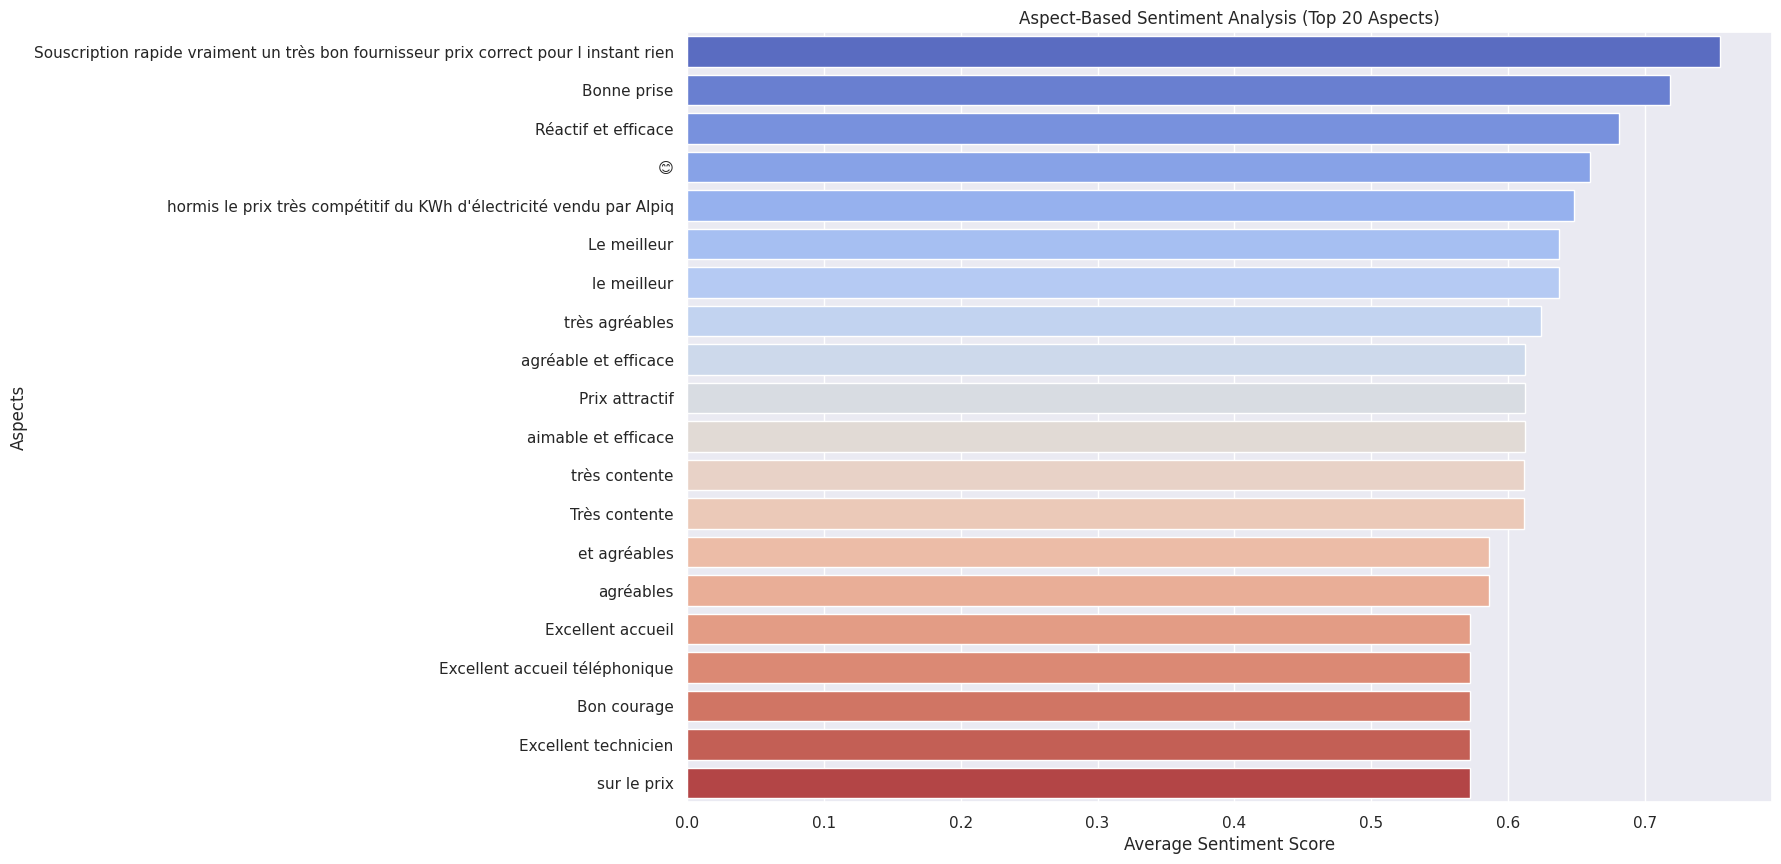

In [ ]:
######Analysis 1: Aspect-Based Sentiment Analysis######
#The objective of Aspect-Based Sentiment Analysis (ABSA) is to identify specific aspects or features of a product or service mentioned in customer reviews and determine the sentiment expressed towards each aspect.
#This allows businesses to pinpoint specific areas of their offerings that are performing well or need improvement based on customer feedback.
#We will use SpaCy for dependency parsing to extract aspects and VADER for sentiment analysis to determine the sentiment of each aspect.
import spacy
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to extract aspects and sentiment
def extract_aspects_and_sentiment(text):
    doc = nlp(text)
    aspects = []
    sentiments = []
    for chunk in doc.noun_chunks:
        aspect = chunk.text
        aspects.append(aspect)
        sentiment = analyzer.polarity_scores(aspect)["compound"]
        sentiments.append(sentiment)
    return aspects, sentiments

# Apply the function to the reviews
reviews['aspects'], reviews['aspect_sentiments'] = zip(*reviews['verbatim'].apply(extract_aspects_and_sentiment))

# Explode the lists to separate rows for each aspect
aspect_df = reviews.explode(['aspects', 'aspect_sentiments'])

# Aggregate sentiment scores by aspect
aspect_sentiment_summary = aspect_df.groupby('aspects')['aspect_sentiments'].mean().reset_index()

# Filter out aspects mentioned less frequently for clarity
min_count = 5
aspect_counts = aspect_df['aspects'].value_counts()
filtered_aspects = aspect_counts[aspect_counts >= min_count].index
aspect_sentiment_summary = aspect_sentiment_summary[aspect_sentiment_summary['aspects'].isin(filtered_aspects)]

# Sort aspects by sentiment score
aspect_sentiment_summary = aspect_sentiment_summary.sort_values(by='aspect_sentiments', ascending=False)

# Limit the number of aspects displayed
top_n = 20
aspect_sentiment_summary = aspect_sentiment_summary.head(top_n)

### Plot the Top 20 aspects with highest sentiment scores
plt.figure(figsize=(14, 10))
sns.barplot(x='aspect_sentiments', y='aspects', data=aspect_sentiment_summary, palette='coolwarm')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Aspects')
plt.title('Aspect-Based Sentiment Analysis (Top 20 Aspects)')
plt.show()

                      aspects aspect_sentiments
39395         Une catastrophe           -0.6597
123133        une catastrophe           -0.6597
83738          la catastrophe           -0.6597
51645   c'est une catastrophe           -0.6597
31920      Profiteur de crise           -0.6486
...                       ...               ...
117438               sérieuse           -0.0258
78004            j'ai attendu           -0.0258
35727                Sérieuse           -0.0258
34901        Société sérieuse           -0.0258
16106     Entreprise sérieuse           -0.0258

[276 rows x 2 columns]


<ipython-input-30-291f2a26cc00>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='aspect_sentiments', y='aspects', data=negative_aspects_top, palette='coolwarm')


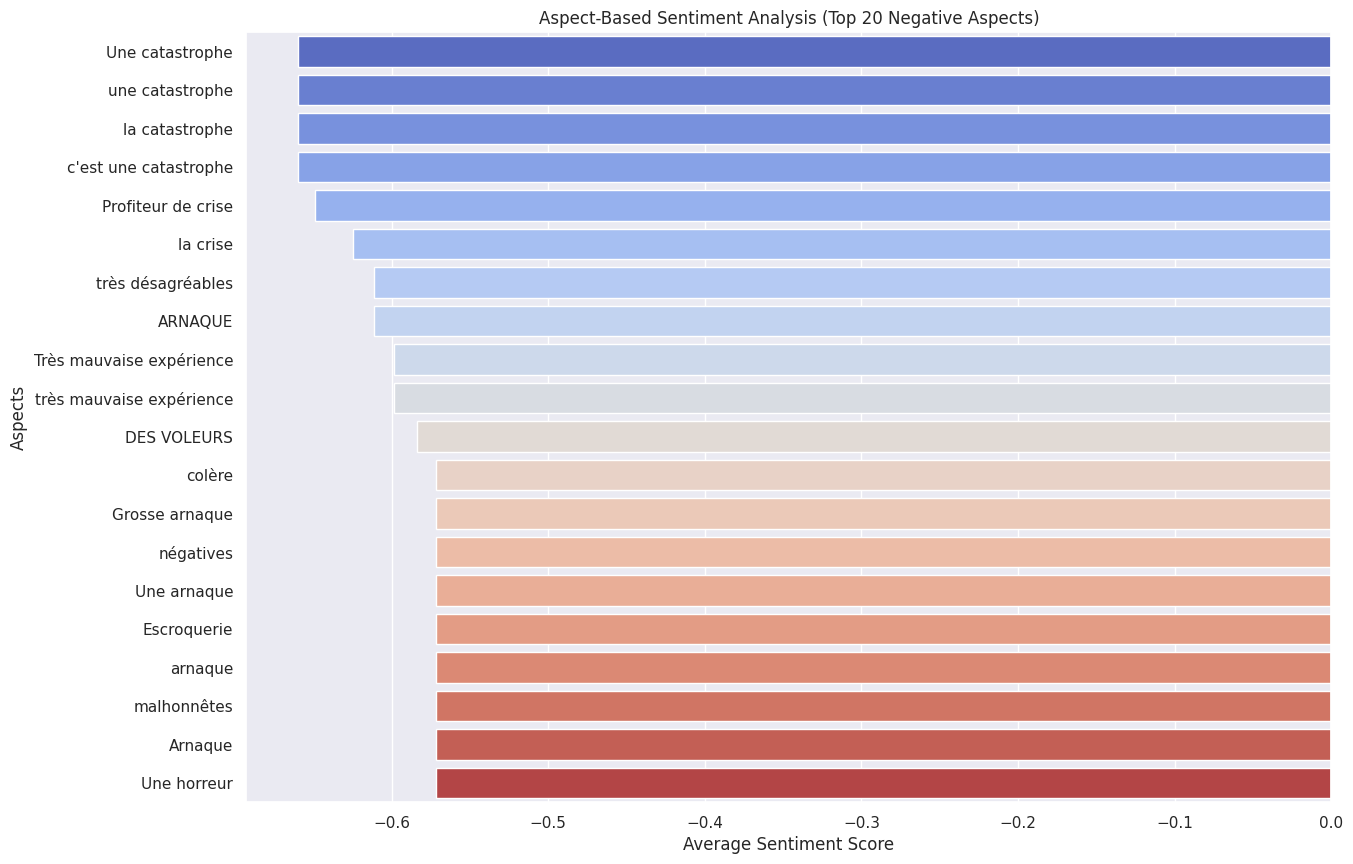

In [ ]:
### Plot the Top 20 aspects with lowest sentiment scores
import spacy
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to extract aspects and sentiment
def extract_aspects_and_sentiment(text):
    doc = nlp(text)
    aspects = []
    sentiments = []
    for chunk in doc.noun_chunks:
        aspect = chunk.text
        aspects.append(aspect)
        sentiment = analyzer.polarity_scores(aspect)["compound"]
        sentiments.append(sentiment)
    return aspects, sentiments

# Apply the function to the reviews
reviews['aspects'], reviews['aspect_sentiments'] = zip(*reviews['verbatim'].apply(extract_aspects_and_sentiment))

# Explode the lists to separate rows for each aspect
aspect_df = reviews.explode(['aspects', 'aspect_sentiments'])

# Aggregate sentiment scores by aspect
aspect_sentiment_summary = aspect_df.groupby('aspects')['aspect_sentiments'].mean().reset_index()

# Filter out aspects mentioned less frequently for clarity (optional)
min_count = 5
aspect_counts = aspect_df['aspects'].value_counts()
filtered_aspects = aspect_counts[aspect_counts >= min_count].index
aspect_sentiment_summary = aspect_sentiment_summary[aspect_sentiment_summary['aspects'].isin(filtered_aspects)]

# Filter aspects to retain only those with negative sentiment scores
negative_aspects = aspect_sentiment_summary[aspect_sentiment_summary['aspect_sentiments'] < 0]

# Sort aspects by sentiment score in ascending order
negative_aspects = negative_aspects.sort_values(by='aspect_sentiments', ascending=True)

# Print the filtered negative aspects
print(negative_aspects)

# Optionally, visualize the negative aspects
# Limit the number of aspects displayed to the top 20 negative aspects
top_n = 20
negative_aspects_top = negative_aspects.head(top_n)

# Plot the sentiment scores for aspects with the lowest sentiment scores
plt.figure(figsize=(14, 10))
sns.barplot(x='aspect_sentiments', y='aspects', data=negative_aspects_top, palette='coolwarm')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Aspects')
plt.title('Aspect-Based Sentiment Analysis (Top 20 Negative Aspects)')
plt.show()

Interpretation of the Plot

The bar plot visualizes the average sentiment scores for the top 20 aspects. Here’s how to interpret it:

	•	Aspects with High Positive Scores: These aspects are mentioned positively by customers. For example, if “quality” has a high positive score, it means customers are generally happy with the quality.
	•	Aspects with High Negative Scores: These aspects are mentioned negatively by customers. For example, if “price” has a high negative score, it means customers are generally unhappy with the price.
	•	Aspects with Scores Around Zero: These aspects are mentioned in a neutral context, or opinions about them are mixed.


**######Analysis 2######**

In [ ]:
######Analysis 2: Customer Journey Mapping######
#categorize customer reviews into different stages of the customer journey and analyzing the sentiment at each stage
# Define customer journey stages and associated keywords in French
customer_journey_stages = {
    'Acquisition': ['publicité', 'marque', 'promotion', 'connu', 'inscription', 'abonnement', 'souscrire', 'contrat'],
    'Activation': ['activer', 'installation', 'démarrage', 'première utilisation', 'mise en service'],
    'Service Utilization': ['utiliser', 'utilisation', 'expérience', 'fonctionnement', 'service'],
    'Customer Support': ['support', 'aide', 'service client', 'assistance', 'problème', 'réclamation'],
    'Retention': ['renouveler', 'abonnement', 'fidélité', 'répétez', 'retour', 'conserver', 'rester']
}

# Function to categorize reviews into customer journey stages
def categorize_review(text):
    text = text.lower()
    for stage, keywords in customer_journey_stages.items():
        if any(keyword in text for keyword in keywords):
            return stage
    return 'Other'

# Apply the function to categorize each review
reviews['journey_stage'] = reviews['verbatim'].apply(categorize_review)

# Verify that the 'journey_stage' column has been created
print(reviews['journey_stage'].value_counts())


journey_stage
Other                  25022
Service Utilization     5205
Acquisition             4977
Customer Support        1287
Activation               617
Retention                186
Name: count, dtype: int64


In [ ]:
#Use VADER to perform sentiment analysis for reviews at each stage.
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

# Apply sentiment analysis to each review
reviews['sentiment'] = reviews['verbatim'].apply(analyze_sentiment)

# Aggregate sentiment scores by journey stage
stage_sentiment_summary = reviews.groupby('journey_stage')['sentiment'].mean().reset_index()

# Display the sentiment summary for each stage
print(stage_sentiment_summary)

         journey_stage  sentiment
0          Acquisition   0.123642
1           Activation   0.222914
2     Customer Support   0.103572
3                Other   0.235924
4            Retention   0.127357
5  Service Utilization   0.232856


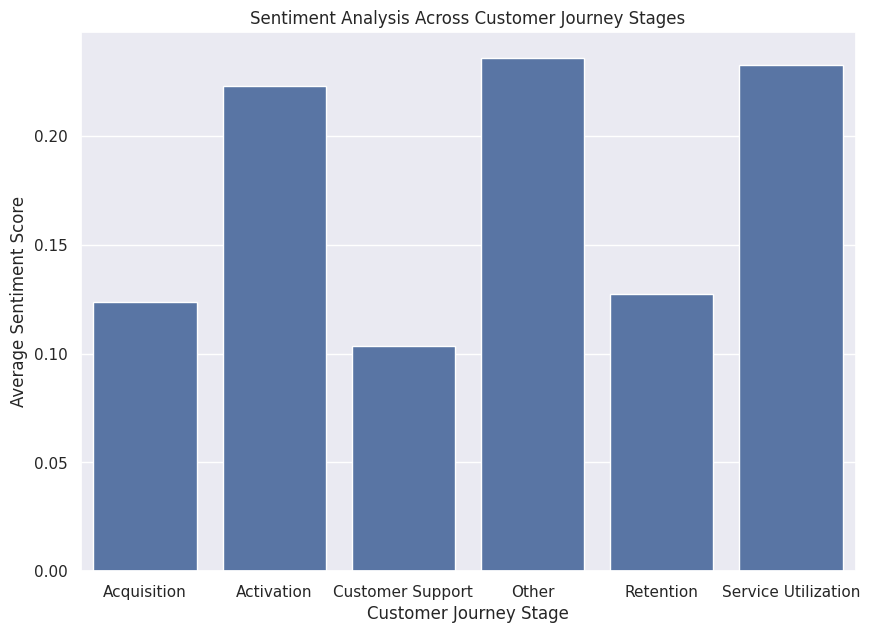

In [ ]:

# Plot the sentiment scores for each customer journey stage
plt.figure(figsize=(10, 7))
sns.barplot(x='journey_stage', y='sentiment', data=stage_sentiment_summary)
plt.xlabel('Customer Journey Stage')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Analysis Across Customer Journey Stages')
plt.show()

	1.	Customer Journey Stages:
	•	Reviews are categorized into stages like Acquisition, Activation, Service Utilization, Customer Support, and Retention based on French keywords.
	2.	Sentiment Analysis:
	•	Sentiment analysis is performed for reviews at each stage to determine the average sentiment score.
	3.	Visualization:
	•	A bar plot visualizes the average sentiment score for each customer journey stage, helping identify stages with positive or negative customer feedback.


Further sort out the stages with most negative sentiment reviews

In [ ]:
#Further sort out the stages with most negative sentiment reviews
# Function to categorize reviews into customer journey stages
def categorize_review(text):
    text = text.lower()
    for stage, keywords in customer_journey_stages.items():
        if any(keyword in text for keyword in keywords):
            return stage
    return 'Other'

# Apply the function to categorize each review
reviews['journey_stage'] = reviews['verbatim'].apply(categorize_review)

# Display the distribution of reviews across different stages
print(reviews['journey_stage'].value_counts())

journey_stage
Other                  25022
Service Utilization     5205
Acquisition             4977
Customer Support        1287
Activation               617
Retention                186
Name: count, dtype: int64


In [ ]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

# Apply sentiment analysis to each review
reviews['sentiment'] = reviews['verbatim'].apply(analyze_sentiment)

In [ ]:
# Filter reviews with negative sentiment scores
negative_reviews = reviews[reviews['sentiment'] < 0]

# Aggregate sentiment scores by journey stage for negative reviews
negative_stage_sentiment_summary = negative_reviews.groupby('journey_stage')['sentiment'].mean().reset_index()

# Display the sentiment summary for each stage with negative reviews
print(negative_stage_sentiment_summary)

         journey_stage  sentiment
0          Acquisition  -0.594675
1           Activation  -0.462759
2     Customer Support  -0.443906
3                Other  -0.363690
4            Retention  -0.600710
5  Service Utilization  -0.581206


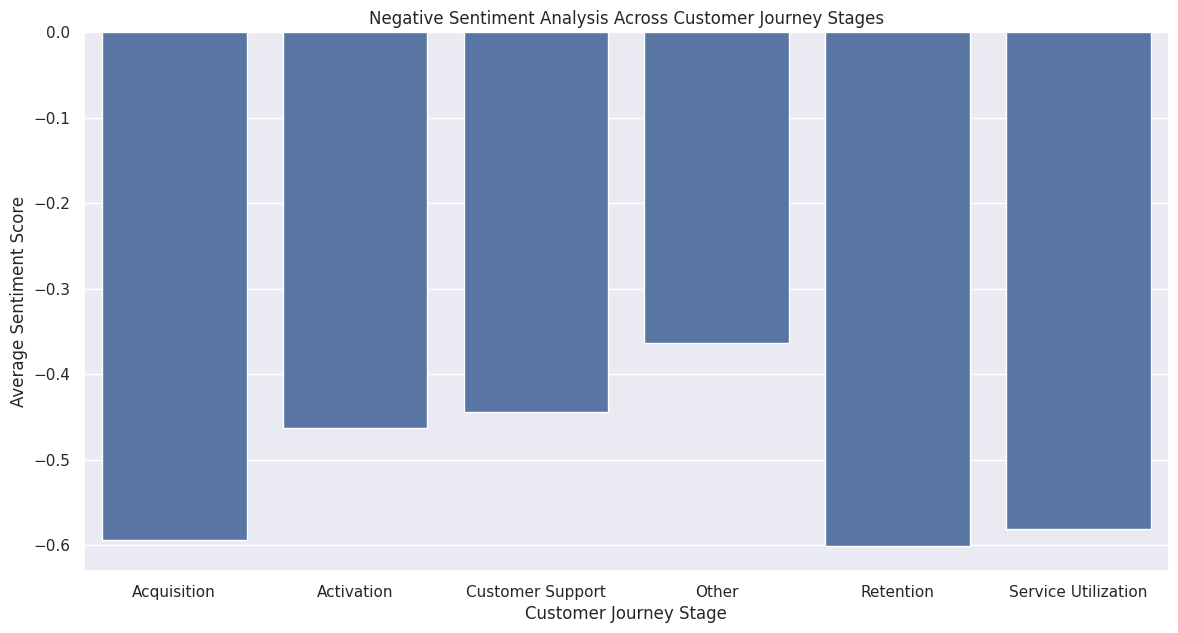

In [ ]:

# Plot the sentiment scores for each customer journey stage with negative reviews
plt.figure(figsize=(14, 7))
sns.barplot(x='journey_stage', y='sentiment', data=negative_stage_sentiment_summary)
plt.xlabel('Customer Journey Stage')
plt.ylabel('Average Sentiment Score')
plt.title('Negative Sentiment Analysis Across Customer Journey Stages')
plt.show()

**Deeper Analysis of Customer Journey and Identification of Pain Points**

In [ ]:
import spacy

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Function to tokenize and lemmatize text
def lemmatize_and_tokenize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Apply the function to create the column
reviews['tokens_lem_processed'] = reviews['verbatim'].apply(lemmatize_and_tokenize)

In [ ]:
# Prepare lemmatized tokenized reviews for topic modeling
tokens = reviews['tokens_lem_processed'].tolist()

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in tokens]

# Function to perform LDA for each journey stage
def lda_for_stage(stage, num_topics=5):
    stage_reviews = reviews[reviews['journey_stage'] == stage]
    stage_corpus = [dictionary.doc2bow(text) for text in stage_reviews['tokens_lem_processed']]
    lda_model = LdaModel(stage_corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)
    return lda_model

# Perform LDA for each stage
stages = reviews['journey_stage'].unique()
lda_models = {stage: lda_for_stage(stage) for stage in stages}

# Display topics for each stage
for stage, model in lda_models.items():
    print(f"\nStage: {stage}")
    topics = model.print_topics(num_words=5)
    for topic in topics:
        print(topic)


Stage: Service Utilization
(0, '0.018*"votre" + 0.018*"nous" + 0.014*"réponse" + 0.014*"prélèvement" + 0.013*"\n\n"')
(1, '0.012*"été" + 0.012*"technicien" + 0.011*"ma" + 0.009*"j\'ai" + 0.009*"nous"')
(2, '0.017*"facture" + 0.009*"mois" + 0.009*"leur" + 0.009*"ma" + 0.008*"€"')
(3, '0.018*"chez" + 0.015*"c\'est" + 0.014*"passé" + 0.013*"Total" + 0.013*"plutôt"')
(4, '0.025*"bon" + 0.020*"recommande" + 0.019*"rapide" + 0.016*"efficace" + 0.015*"suis"')

Stage: Acquisition
(0, '0.029*"prix" + 0.028*"votre" + 0.018*"\n\n" + 0.016*"ou" + 0.014*"tarif"')
(1, '0.018*"contrat" + 0.009*"j\'ai" + 0.009*"été" + 0.008*"dans" + 0.008*"jour"')
(2, '0.025*"facture" + 0.017*"mois" + 0.013*"contrat" + 0.012*"\n\n" + 0.011*"chez"')
(3, '0.023*"contrat" + 0.011*"chez" + 0.009*"Total" + 0.008*"fournisseur" + 0.007*"suis"')
(4, '0.042*"nous" + 0.035*"contrat" + 0.018*"inscription" + 0.013*"rapide" + 0.013*"souscrire"')

Stage: Retention
(0, '0.011*"retour" + 0.008*"EDF" + 0.007*"€" + 0.007*"ma" + 0.007*

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Service Utilization
   dominant_topic  sentiment                           topic_keywords
0               0   0.161457  votre, nous, réponse, prélèvement, \n\n
1               1   0.104544          été, technicien, ma, j'ai, nous
2               2  -0.113450               facture, mois, leur, ma, €
3               3   0.438260        chez, c'est, passé, Total, plutôt
4               4   0.471756  bon, recommande, rapide, efficace, suis


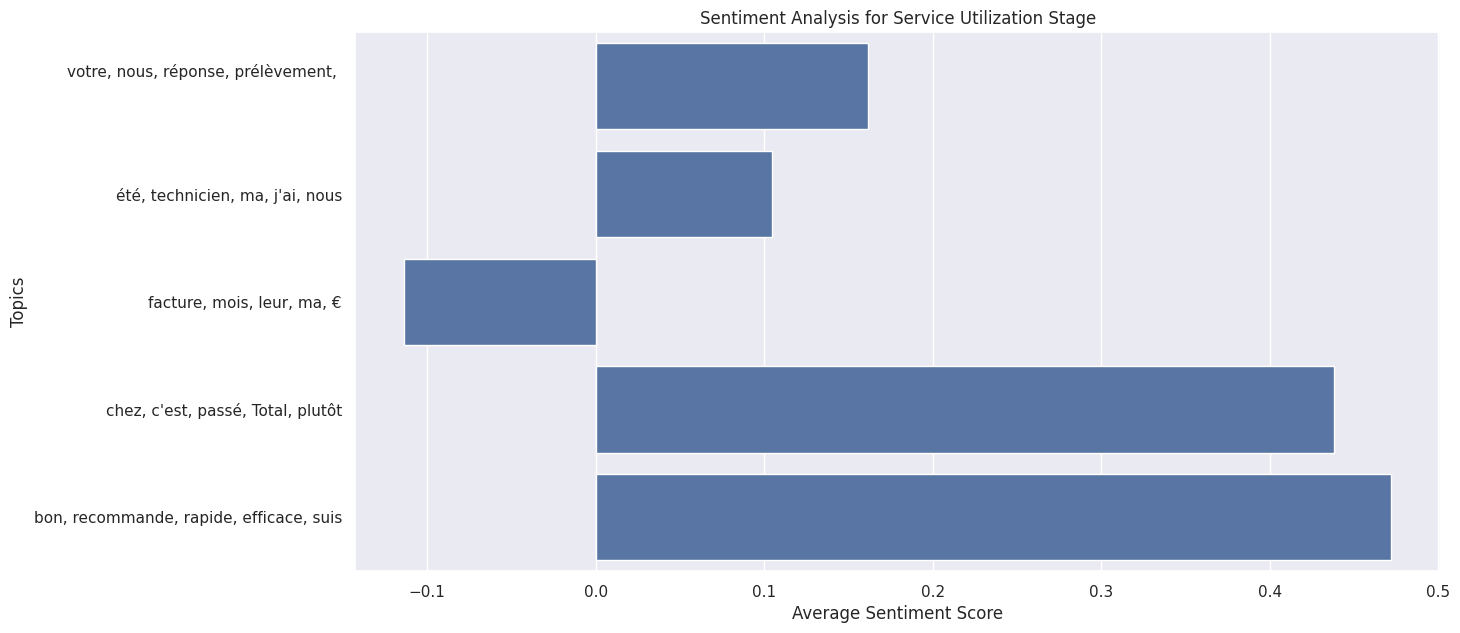

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Acquisition
   dominant_topic  sentiment                                 topic_keywords
0               0   0.376835                   prix, votre, \n\n, ou, tarif
1               1   0.031135                 contrat, j'ai, été, dans, jour
2               2  -0.182034             facture, mois, contrat, \n\n, chez
3               3   0.247578        contrat, chez, Total, fournisseur, suis
4               4   0.387986  nous, contrat, inscription, rapide, souscrire


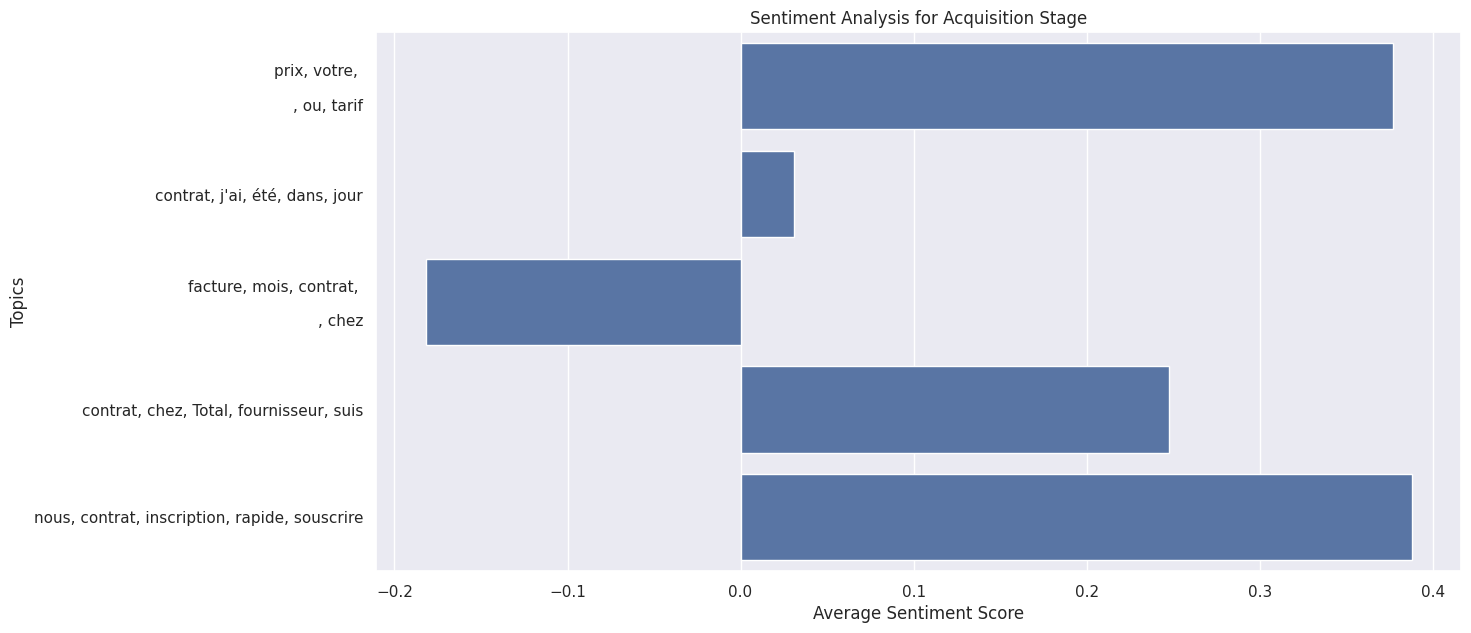

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Retention
   dominant_topic  sentiment                         topic_keywords
0               0   0.259061               retour, EDF, €, ma, chez
1               1   0.065090        chez, nous, EDF, rester, retour
2               2   0.056057      retour, après, rester, fait, chez
3               3   0.106941            chez, mois, suis, total, ma
4               4   0.159979  chez, fournisseur, tout, rester, nous


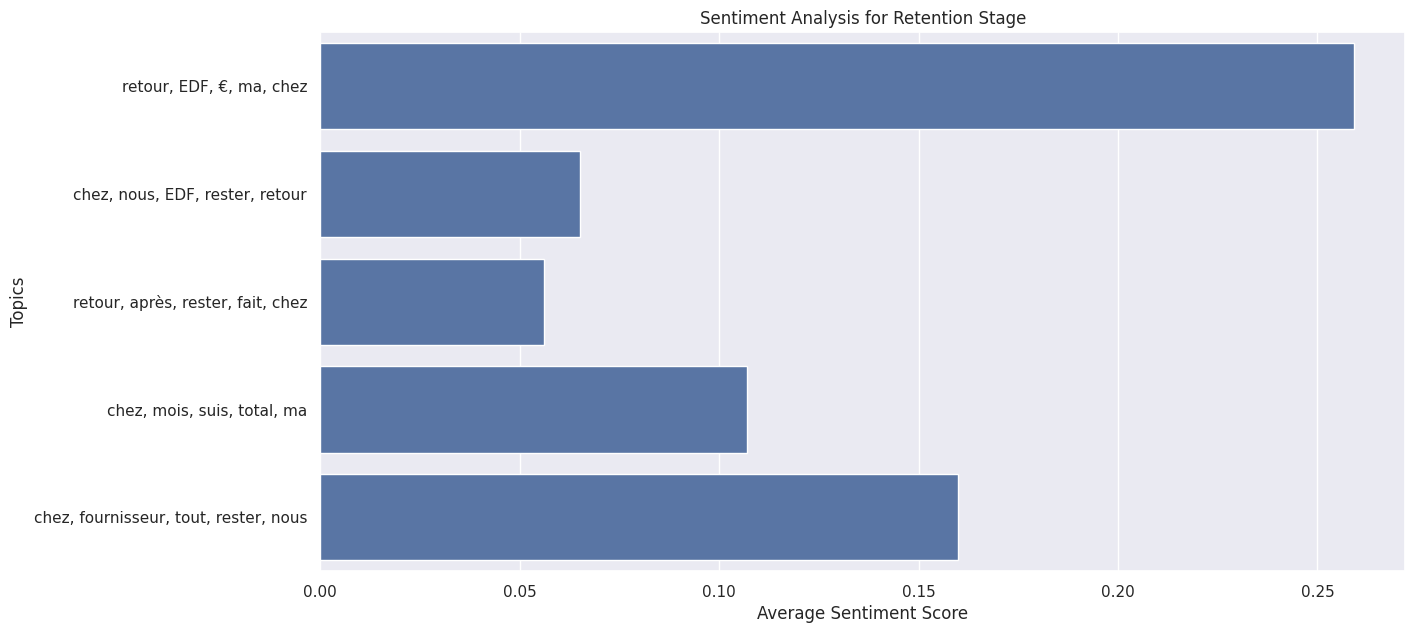

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Other
   dominant_topic  sentiment  \
0               0   0.043650   
1               1   0.283203   
2               2   0.184908   
3               3   0.295364   
4               4   0.337680   

                                      topic_keywords  
0                       mais, jour, même, fait, fois  
1                     nous, technicien, été, Le, son  
2                               rien, l, ai, d, dire  
3     satisfait, suis, fournisseur, prix, satisfaite  
4  professionnel, bon, explication, rapide, efficace  


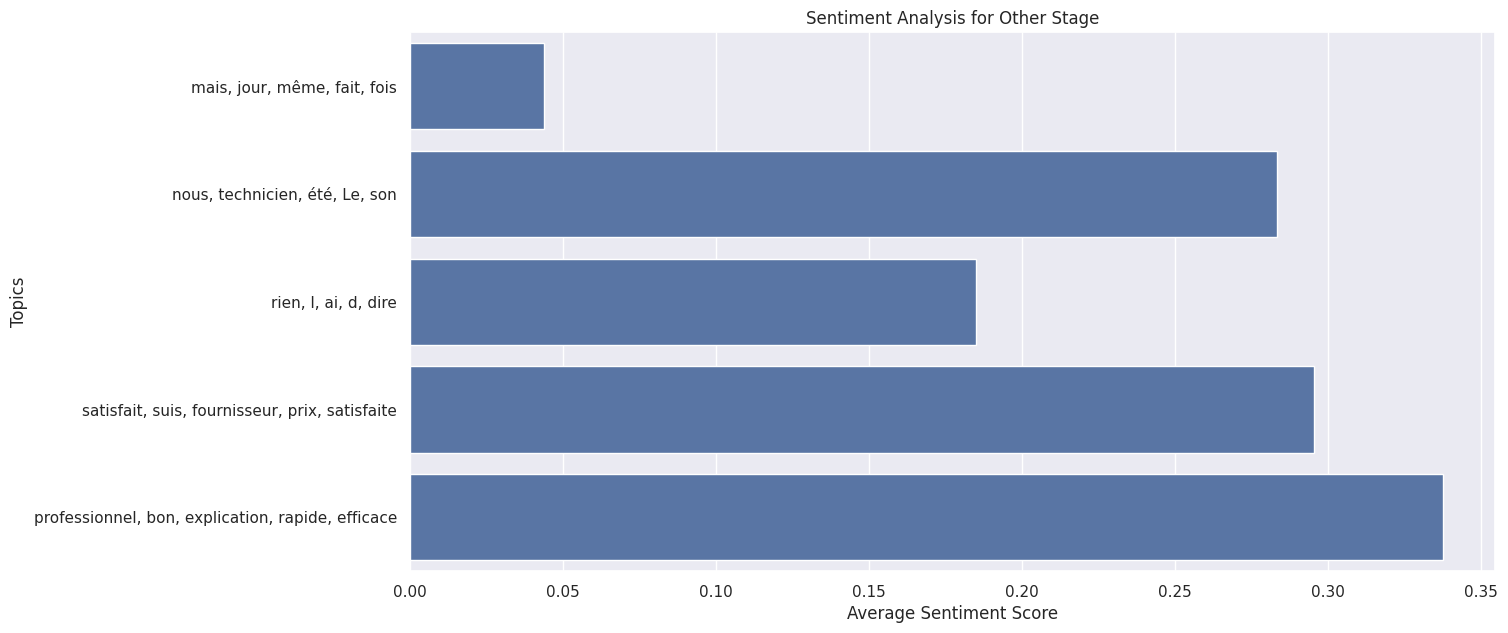

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Customer Support
   dominant_topic  sentiment                             topic_keywords
0               0  -0.133971        mois, facture, j'ai, problème, mais
1               1   0.180539  problème, nous, été, technicien, personne
2               2   0.047050        problème, depuis, chez, facture, eu
3               3   0.036489              problème, été, se, sont, fait
4               4   0.198474   problème, aucun, san, rapide, technicien


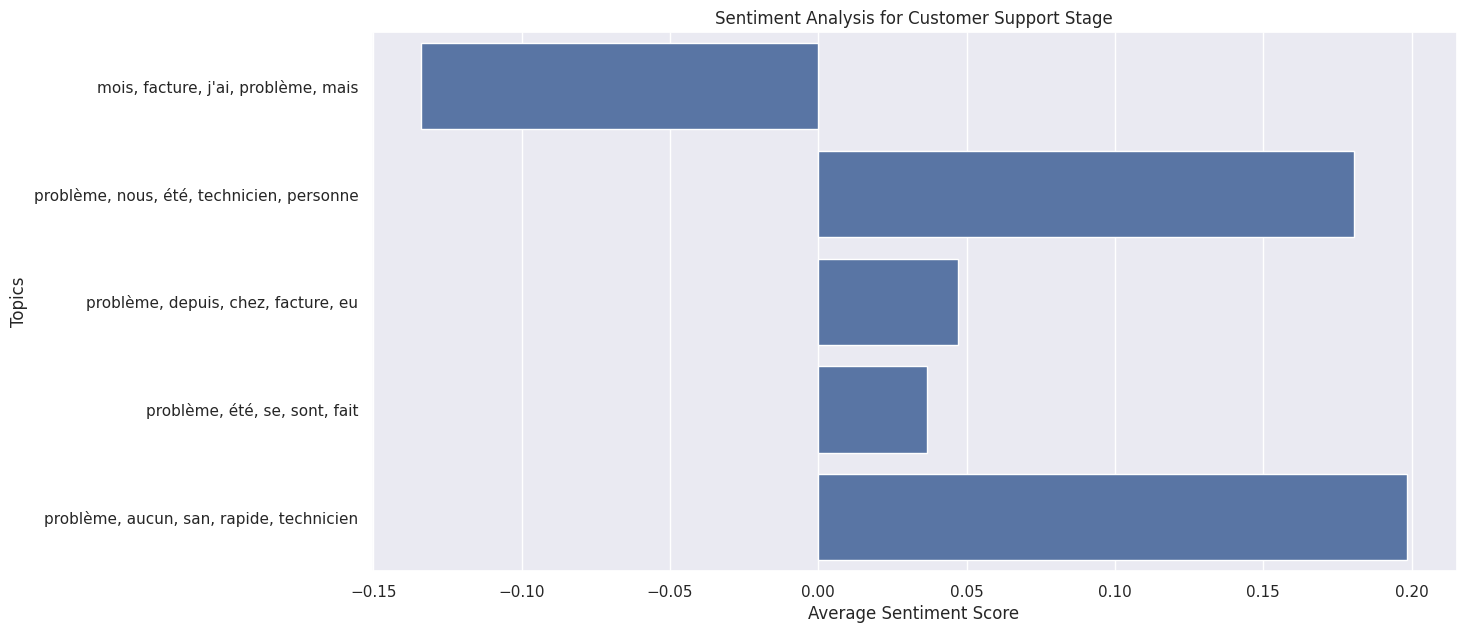

<ipython-input-52-e22cd37a86bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
<ipython-input-52-e22cd37a86bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)



Stage: Activation
   dominant_topic  sentiment  \
0               0   0.135697   
1               1   0.328530   
2               2   0.173059   
3               3   0.191389   
4               4   0.235738   

                                      topic_keywords  
0  l'installation, chaudière, fait, technicien, mois  
1       nous, installation, EDF, été, l'installation  
2        mise, nous, l'installation, l, installation  
3                        mise, tout, dans, jour, été  
4                      nous, mais, mise, gaz, rapide  


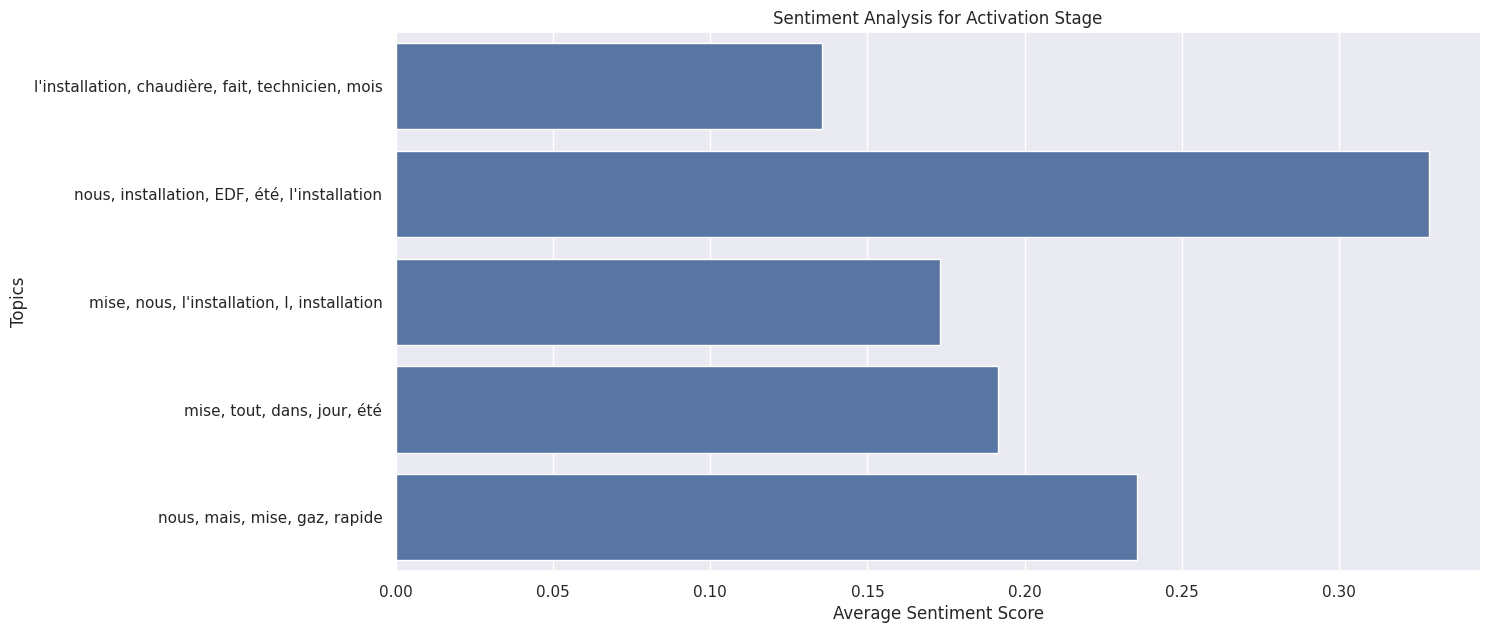

In [ ]:
#Analyze sentiment for each identified topic within each stage.
#Analyze sentiment for each identified topic to determine which issues are causing the most dissatisfaction.
# Function to get dominant topic for each review
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for bow in corpus:
        topic_probs = lda_model[bow]
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Apply dominant topic extraction and sentiment analysis
for stage in stages:
    stage_reviews = reviews[reviews['journey_stage'] == stage]
    stage_corpus = [dictionary.doc2bow(text) for text in stage_reviews['tokens_lem_processed']]
    lda_model = lda_models[stage]
    stage_reviews['dominant_topic'] = get_dominant_topic(lda_model, stage_corpus)
    stage_reviews['sentiment'] = stage_reviews['verbatim'].apply(analyze_sentiment)

    # Aggregate sentiment by dominant topic
    topic_sentiment_summary = stage_reviews.groupby('dominant_topic')['sentiment'].mean().reset_index()
    topic_sentiment_summary['topic_keywords'] = topic_sentiment_summary['dominant_topic'].apply(lambda x: ', '.join([word for word, _ in lda_model.show_topic(x, topn=5)]))

    # Display the sentiment summary for each topic within the stage
    print(f"\nStage: {stage}")
    print(topic_sentiment_summary)

    # Visualize the sentiment scores for each topic within the stage
    plt.figure(figsize=(14, 7))
    sns.barplot(x='sentiment', y='topic_keywords', data=topic_sentiment_summary)
    plt.xlabel('Average Sentiment Score')
    plt.ylabel('Topics')
    plt.title(f'Sentiment Analysis for {stage} Stage')
    plt.show()

**######Analysis 3######**

In [ ]:
######Analysis 3: Pain points during special occasions######
#Identify Relevant Reviews: Filter reviews that mention moving into a new home or winter
#Define keywords related to moving into a new home and winter, and filter reviews based on these keywords.
# Define keywords related to moving into a new home and winter
moving_keywords = ['déménagement', 'nouvelle maison', 'nouveau logement', 'emménagement']
winter_keywords = ['hiver', 'froid', 'chauffage', 'température', 'neige']

# Function to check if a review contains any of the keywords
def contains_keywords(text, keywords):
    text = text.lower()
    return any(keyword in text for keyword in keywords)

# Filter reviews related to moving into a new home
moving_reviews = reviews[reviews['verbatim'].apply(lambda x: contains_keywords(x, moving_keywords))]

# Filter reviews related to winter
winter_reviews = reviews[reviews['verbatim'].apply(lambda x: contains_keywords(x, winter_keywords))]

# Display counts of filtered reviews
print(f"Reviews related to moving: {len(moving_reviews)}")
print(f"Reviews related to winter: {len(winter_reviews)}")

Reviews related to moving: 433
Reviews related to winter: 714


In [ ]:
#Perform Sentiment Analysis: Analyze the sentiment of these filtered reviews to understand overall customer satisfaction
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

# Apply sentiment analysis to moving reviews
moving_reviews['sentiment'] = moving_reviews['verbatim'].apply(analyze_sentiment)

# Apply sentiment analysis to winter reviews
winter_reviews['sentiment'] = winter_reviews['verbatim'].apply(analyze_sentiment)

# Display sentiment summaries
print("Sentiment summary for moving reviews:")
print(moving_reviews['sentiment'].describe())

print("\nSentiment summary for winter reviews:")
print(winter_reviews['sentiment'].describe())

<ipython-input-54-14d03ae74da1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_reviews['sentiment'] = moving_reviews['verbatim'].apply(analyze_sentiment)


Sentiment summary for moving reviews:
count    433.000000
mean       0.042341
std        0.685364
min       -0.986900
25%       -0.687700
50%        0.186700
75%        0.691100
max        0.981700
Name: sentiment, dtype: float64

Sentiment summary for winter reviews:
count    714.000000
mean      -0.018399
std        0.650923
min       -0.989200
25%       -0.663000
50%        0.000000
75%        0.634975
max        0.995300
Name: sentiment, dtype: float64


<ipython-input-54-14d03ae74da1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_reviews['sentiment'] = winter_reviews['verbatim'].apply(analyze_sentiment)


In [ ]:
#Topic Modeling: Apply topic modeling to identify common issues mentioned in the reviews during these specific times.
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Prepare lemmatized tokenized reviews for topic modeling
moving_reviews['tokens'] = moving_reviews['tokens_lem_processed']
winter_reviews['tokens'] = winter_reviews['tokens_lem_processed']

# Create dictionaries and corpora for LDA
moving_dictionary = corpora.Dictionary(moving_reviews['tokens'])
winter_dictionary = corpora.Dictionary(winter_reviews['tokens'])

moving_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
winter_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

moving_corpus = [moving_dictionary.doc2bow(text) for text in moving_reviews['tokens']]
winter_corpus = [winter_dictionary.doc2bow(text) for text in winter_reviews['tokens']]

# Perform LDA for moving reviews
moving_lda_model = LdaModel(moving_corpus, num_topics=5, id2word=moving_dictionary, passes=15, random_state=42)

# Perform LDA for winter reviews
winter_lda_model = LdaModel(winter_corpus, num_topics=5, id2word=winter_dictionary, passes=15, random_state=42)

# Display topics for moving reviews
print("\nTopics for moving reviews:")
moving_topics = moving_lda_model.print_topics(num_words=5)
for topic in moving_topics:
    print(topic)

# Display topics for winter reviews
print("\nTopics for winter reviews:")
winter_topics = winter_lda_model.print_topics(num_words=5)
for topic in winter_topics:
    print(topic)

<ipython-input-55-da87161f9ce7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_reviews['tokens'] = moving_reviews['tokens_lem_processed']
<ipython-input-55-da87161f9ce7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_reviews['tokens'] = winter_reviews['tokens_lem_processed']



Topics for moving reviews:
(0, '0.018*"\n\n" + 0.016*"service" + 0.013*"qui" + 0.012*"client" + 0.012*"au"')
(1, '0.028*"\n" + 0.025*"nous" + 0.017*"vous" + 0.012*"contrat" + 0.012*"des"')
(2, '0.026*"\n" + 0.017*"des" + 0.013*"il" + 0.012*"qui" + 0.012*"service"')
(3, '0.015*"dans" + 0.015*"il" + 0.012*"j\'ai" + 0.010*"des" + 0.009*"plus"')
(4, '0.015*"service" + 0.012*"au" + 0.012*"jour" + 0.012*"dans" + 0.011*"Je"')

Topics for winter reviews:
(0, '0.019*"technicien" + 0.014*"chaudière" + 0.013*"est" + 0.013*"ne" + 0.011*"qui"')
(1, '0.021*"du" + 0.014*"au" + 0.013*"les" + 0.013*"plus" + 0.011*"qui"')
(2, '0.017*"mon" + 0.015*"du" + 0.014*"vous" + 0.014*"nous" + 0.013*"est"')
(3, '0.022*"\n" + 0.018*"vous" + 0.017*"des" + 0.017*"ne" + 0.015*"les"')
(4, '0.023*"\n" + 0.018*"les" + 0.014*"mon" + 0.014*"facture" + 0.012*"ne"')


<ipython-input-56-15275e468813>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_reviews['dominant_topic'] = get_dominant_topic(moving_lda_model, moving_corpus)
<ipython-input-56-15275e468813>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_reviews['sentiment'] = moving_reviews['verbatim'].apply(analyze_sentiment)



Sentiment for topics in moving reviews:
   dominant_topic  sentiment                  topic_keywords
0               0   0.150962  \n\n, service, qui, client, au
1               1  -0.043933    \n, nous, vous, contrat, des
2               2  -0.003260       \n, des, il, qui, service
3               3   0.005528       dans, il, j'ai, des, plus
4               4   0.159719     service, au, jour, dans, Je


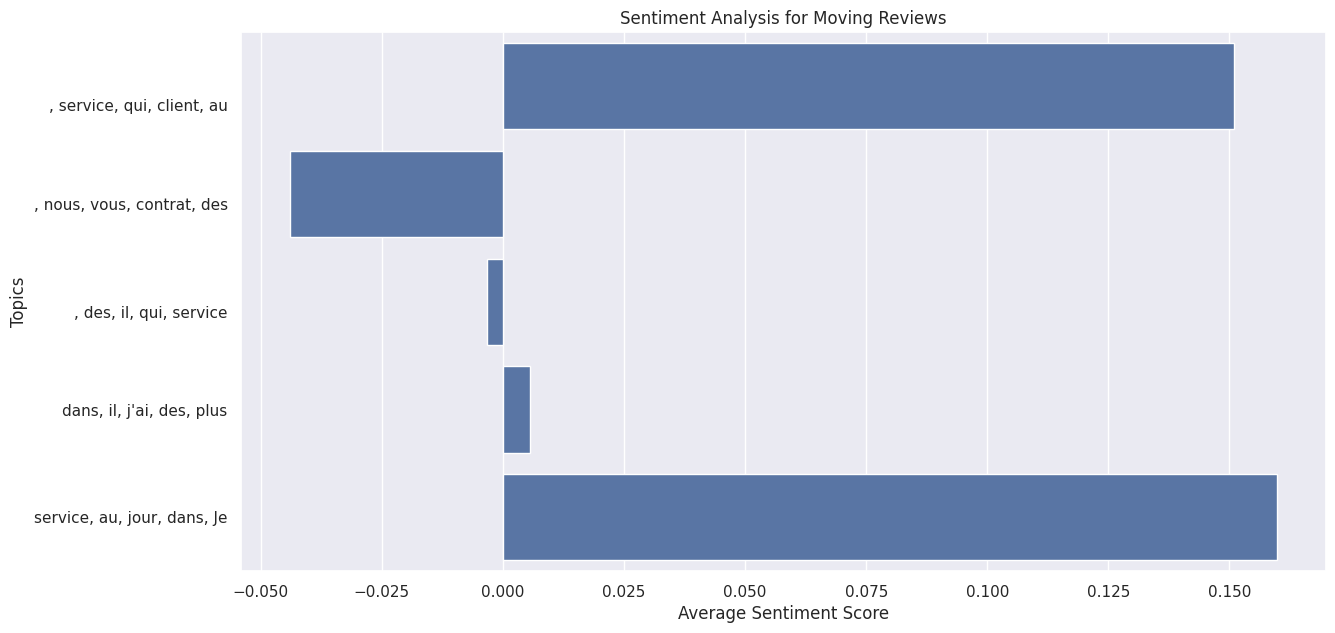

<ipython-input-56-15275e468813>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_reviews['dominant_topic'] = get_dominant_topic(winter_lda_model, winter_corpus)
<ipython-input-56-15275e468813>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter_reviews['sentiment'] = winter_reviews['verbatim'].apply(analyze_sentiment)



Sentiment for topics in winter reviews:
   dominant_topic  sentiment                       topic_keywords
0               0  -0.014196  technicien, chaudière, est, ne, qui
1               1   0.080390               du, au, les, plus, qui
2               2   0.210135             mon, du, vous, nous, est
3               3  -0.053340               \n, vous, des, ne, les
4               4  -0.096413            \n, les, mon, facture, ne


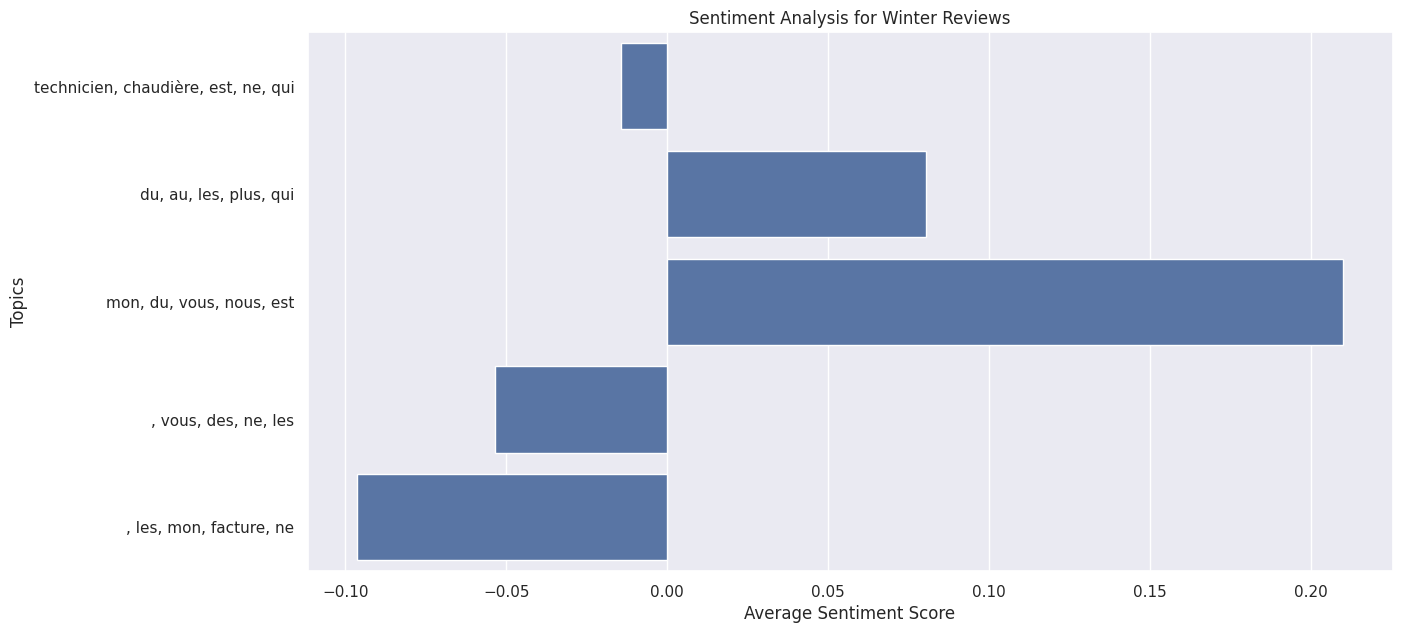

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get dominant topic for each review
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for bow in corpus:
        topic_probs = lda_model[bow]
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Apply dominant topic extraction and sentiment analysis for moving reviews
moving_reviews['dominant_topic'] = get_dominant_topic(moving_lda_model, moving_corpus)
moving_reviews['sentiment'] = moving_reviews['verbatim'].apply(analyze_sentiment)

# Aggregate sentiment by dominant topic for moving reviews
moving_topic_sentiment_summary = moving_reviews.groupby('dominant_topic')['sentiment'].mean().reset_index()
moving_topic_sentiment_summary['topic_keywords'] = moving_topic_sentiment_summary['dominant_topic'].apply(lambda x: ', '.join([word for word, _ in moving_lda_model.show_topic(x, topn=5)]))

# Display the sentiment summary for each topic within the stage
print("\nSentiment for topics in moving reviews:")
print(moving_topic_sentiment_summary)

# Visualize the sentiment scores for each topic within the stage
plt.figure(figsize=(14, 7))
sns.barplot(x='sentiment', y='topic_keywords', data=moving_topic_sentiment_summary)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Topics')
plt.title('Sentiment Analysis for Moving Reviews')
plt.show()

# Apply dominant topic extraction and sentiment analysis for winter reviews
winter_reviews['dominant_topic'] = get_dominant_topic(winter_lda_model, winter_corpus)
winter_reviews['sentiment'] = winter_reviews['verbatim'].apply(analyze_sentiment)

# Aggregate sentiment by dominant topic for winter reviews
winter_topic_sentiment_summary = winter_reviews.groupby('dominant_topic')['sentiment'].mean().reset_index()
winter_topic_sentiment_summary['topic_keywords'] = winter_topic_sentiment_summary['dominant_topic'].apply(lambda x: ', '.join([word for word, _ in winter_lda_model.show_topic(x, topn=5)]))

# Display the sentiment summary for each topic within the stage
print("\nSentiment for topics in winter reviews:")
print(winter_topic_sentiment_summary)

# Visualize the sentiment scores for each topic within the stage
plt.figure(figsize=(14, 7))
sns.barplot(x='sentiment', y='topic_keywords', data=winter_topic_sentiment_summary)
plt.xlabel('Average Sentiment Score')
plt.ylabel('Topics')
plt.title('Sentiment Analysis for Winter Reviews')
plt.show()


Negative sentiment for topics in moving reviews:
   dominant_topic  sentiment                topic_keywords
1               1  -0.043933  \n, nous, vous, contrat, des
2               2  -0.003260     \n, des, il, qui, service

Negative sentiment for topics in winter reviews:
   dominant_topic  sentiment                       topic_keywords
0               0  -0.014196  technicien, chaudière, est, ne, qui
3               3  -0.053340               \n, vous, des, ne, les
4               4  -0.096413            \n, les, mon, facture, ne


<ipython-input-57-0eca123f339d>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='topic_keywords', data=negative_moving_topics, palette='coolwarm')


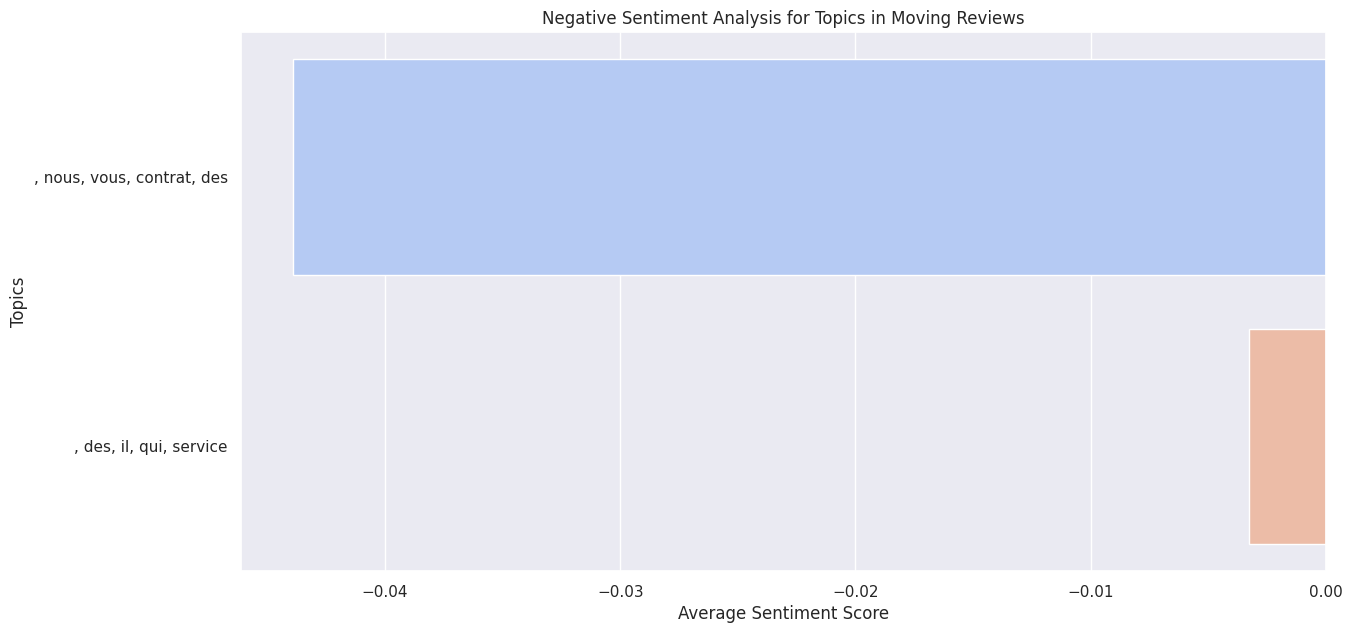

<ipython-input-57-0eca123f339d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment', y='topic_keywords', data=negative_winter_topics, palette='coolwarm')


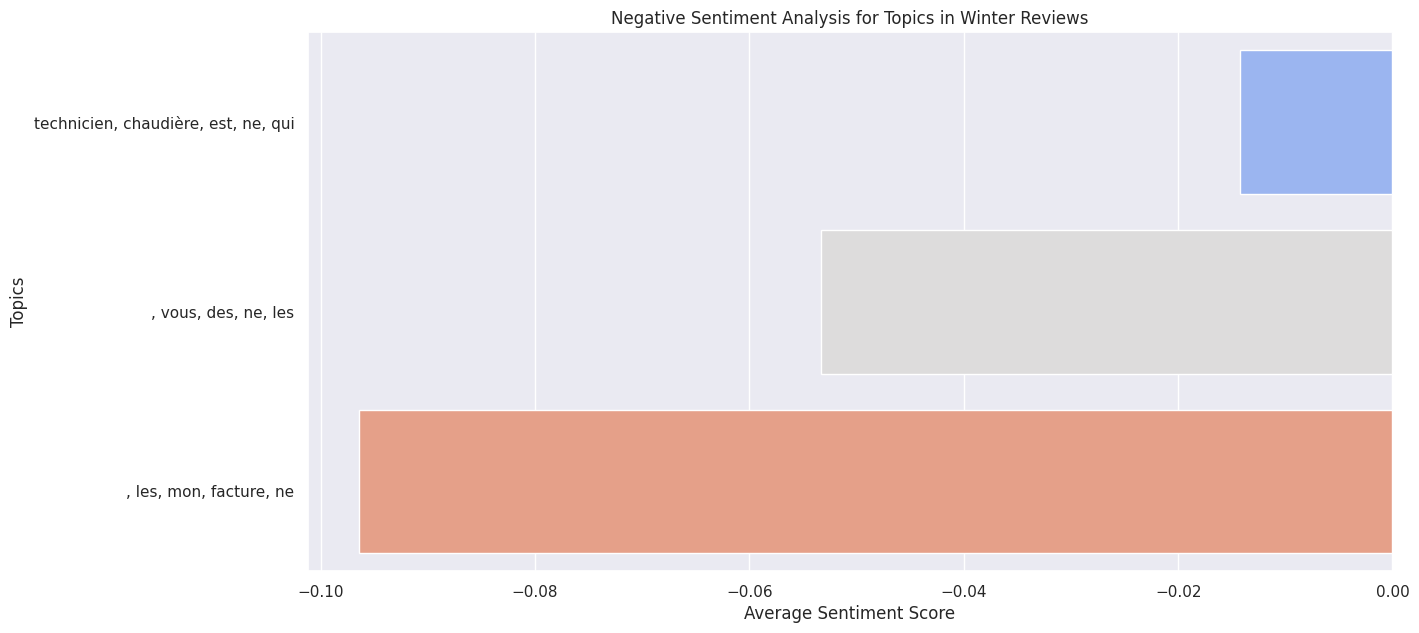

In [ ]:
####Filter and Visualize Negative Sentiment Topics
# Filter topics with negative sentiment scores for moving reviews
negative_moving_topics = moving_topic_sentiment_summary[moving_topic_sentiment_summary['sentiment'] < 0]

# Filter topics with negative sentiment scores for winter reviews
negative_winter_topics = winter_topic_sentiment_summary[winter_topic_sentiment_summary['sentiment'] < 0]

# Display the negative sentiment summary for each topic within the special occasions
print("\nNegative sentiment for topics in moving reviews:")
print(negative_moving_topics)

print("\nNegative sentiment for topics in winter reviews:")
print(negative_winter_topics)

# Plot the sentiment scores for negative topics in moving reviews
plt.figure(figsize=(14, 7))
sns.barplot(x='sentiment', y='topic_keywords', data=negative_moving_topics, palette='coolwarm')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Topics')
plt.title('Negative Sentiment Analysis for Topics in Moving Reviews')
plt.show()

# Plot the sentiment scores for negative topics in winter reviews
plt.figure(figsize=(14, 7))
sns.barplot(x='sentiment', y='topic_keywords', data=negative_winter_topics, palette='coolwarm')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Topics')
plt.title('Negative Sentiment Analysis for Topics in Winter Reviews')
plt.show()